In [36]:
import multiprocessing
import csv
import random

def encounter(A_cooperation, B_cooperation, s):
    if A_cooperation:
        if B_cooperation:
            return (s, s) # (C, C)
        else:
            return (1, s+1) # (C, D)
    else:
        if B_cooperation:
            return (s+1, 1) # (D, C)
        else:
            return (2, 2) # (D, D)

# default: k = 1
def one_trial(s, p, log_data):
    # Fixed parameters
    N = 1000
    n = 3

    # Initial configuration: all play defect except central 10 individuals play cooperate
    agents = [False for i in range(N)] # True: Cooperation ; False: Defect
    start = int((N-10)/2) + 1
    for i in range(start, start+10):
        agents[i] = True

    mutatant_winnig = False
    next_period = True
    period_num = 0
    while next_period:
        ### One period start ###
        learing_person_index = random.randrange(N)    
        
        # calculated the average payoff of each individual -> 其實最多只需要計算該人選前後n個人的average_payoffs
        average_payoffs = [0 for i in range(N)]
        for i in range(learing_person_index-n-1, learing_person_index+n+1):
            if i >= 0 and i+1 < N:
                payoffs = encounter(agents[i], agents[i+1], s)
                average_payoffs[i] += (payoffs[0] / 2)
                average_payoffs[i+1] += (payoffs[1] / 2)
        average_payoffs[0] *= 2
        average_payoffs[N-1] *= 2  

        # test whether he was permitted to learn
        learn_prob = 0
        if learing_person_index-1 >= 0:
            if agents[learing_person_index] != agents[learing_person_index-1]: learn_prob = 1
        if learing_person_index+1 < N:
            if agents[learing_person_index] != agents[learing_person_index+1]: learn_prob = 1
        if p <= 2: # 2 >= p >= 1
            if learn_prob == 0 and learing_person_index-2 >= 0:
                if agents[learing_person_index] != agents[learing_person_index-2]: learn_prob = p-1
            if learn_prob == 0 and learing_person_index+2 < N:
                if agents[learing_person_index] != agents[learing_person_index+2]: learn_prob = p-1
        else: # 3 >= p >= 2
            if learn_prob == 0 and learing_person_index-2 >= 0:
                if agents[learing_person_index] != agents[learing_person_index-2]: learn_prob = 1
            if learn_prob == 0 and learing_person_index+2 < N:
                if agents[learing_person_index] != agents[learing_person_index+2]: learn_prob = 1
            if learn_prob == 0 and learing_person_index-3 >= 0:
                if agents[learing_person_index] != agents[learing_person_index-3]: learn_prob = p-2
            if learn_prob == 0 and learing_person_index+3 < N:
                if agents[learing_person_index] != agents[learing_person_index+3]: learn_prob = p-2
        learn = random.choices([True, False], weights=[learn_prob, 1-learn_prob])[0]   

        # stochastic learing 
        if learn:
            learning_neighborhood = []
            learning_neighborhood_payoffs = []
            for i in range(learing_person_index-n, learing_person_index+n+1):
                if i >= 0 and i < N: 
                    learning_neighborhood.append(i)
                    learning_neighborhood_payoffs.append(average_payoffs[i])   

            guru_index = random.choices(learning_neighborhood, weights=learning_neighborhood_payoffs)[0]
            agents[learing_person_index] = agents[guru_index]
        ### One period end ###    

        period_num += 1
        if period_num >= 10**2:
            next_period = False    

        if len(set(agents)) == 1:
            next_period = False
            mutatant_winnig = set(agents) == {True}

    log_data.append([s, p, mutatant_winnig])
    # return mutatant_winnig

In [29]:
a = []
one_trial(3, 1.5, a)
a

[[3, 1.5, False]]

In [40]:
if __name__ == '__main__':
    random.seed(8)

    n_cpus = multiprocessing.cpu_count()
    manager = multiprocessing.Manager()
    log_data = manager.list()

    trial_num = 3
    args = []
    for s in [3, 5, 7]:
        for p in [p*0.1 for p in range(10, 30, 1)]:
            args.append((s, p, log_data))
    args = args * trial_num

    print("cpu count: {}".format(n_cpus))
    pool = multiprocessing.Pool(n_cpus+2)
    pool.starmap(one_trial, args)

cpu count: 8


In [42]:
with open('data.csv', 'w', newline='') as output_file:
    writer = csv.writer(output_file)
    writer.writerow(['S', 'P', 'Mutatant Winnig'])
    for data in log_data:
        writer.writerow(data)

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data.csv')  

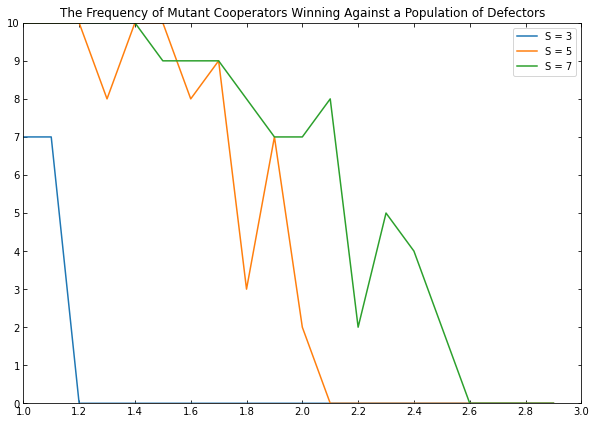

In [35]:
data = df.groupby(['S', 'P']).sum()
data = data.reset_index()
data.columns = ['S', 'P', 'Frequency']

x = np.array(data[data['S'] == 5]['P'])
x = np.array(data[data.S == 5].P)
y1 = np.array(data[data.S == 3].Frequency)
y2 = np.array(data[data.S == 5].Frequency)
y3 = np.array(data[data.S == 7].Frequency)

fig, ax= plt.subplots(1, 1, figsize=(11, 8))
ax.plot(x, y1, label = "S = 3")
ax.plot(x, y2, label = "S = 5")
ax.plot(x, y3, label = "S = 7")


ax.set_ylim(0, 10)
ax.set_yticks(np.array(range(0, 11, 1)))
ax.set_xlim(1, 3)
ax.set_xticks(np.arange(1.0, 3.01, 0.2))
ax.tick_params(direction="in", top="on", right="on")

fig.set_facecolor('white')
plt.title("The Frequency of Mutant Cooperators Winning Against a Population of Defectors")
plt.legend(loc='upper right')
plt.savefig('Figure1.jpg')
plt.show()